In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.utils.data as data_utils

from math import pi, log
from BBSVI import SVI
%matplotlib inline

# Load data

In [2]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)

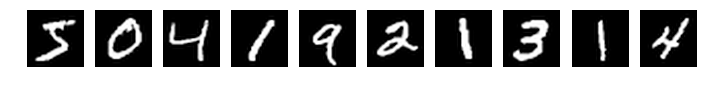

In [3]:
def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 28, 28)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(train_data[:10][0])

# Functions

# Avtoencoder: 

In [4]:
class Encoder(object):    
    
    def __init__(self, encoder_net, data):
        '''Initialization
        
        Args:            
            encoder_net: torch.nn.Network. Should be forward method, that takes data[index] 
                         and returns mu and logsigma
            data: data, should be callable by index
        
        '''
        
        self.net = encoder_net
        self.parameters = encoder_net.parameters
        self.data = data
        
    def sample_global(self):
        return None
        
    def sample_local(self, beta, idx):
        
        mu_idx, logsigma_idx = self.net(self.data[idx].view(1, -1))
        sigma_idx = torch.exp(torch.clamp(logsigma_idx, -10, 10))
        dist_idx = torch.distributions.Normal(mu_idx, sigma_idx)
        output = dist_idx.rsample()

        return output
    

In [5]:
class Decoder(object):
    
    def __init__(self, decoder_net):
        self.net = decoder_net
        self.parameters = decoder_net.parameters
        
    
    def log_likelihood_cond(self, x, z, beta):
        mu_idx, logsigma_idx = self.net(z)
        sigma_idx = torch.exp(torch.clamp(logsigma_idx, -10, 10))
        dist_idx = torch.distributions.Normal(mu_idx, sigma_idx)
        output = torch.sum(dist_idx.log_prob(x))

        return output

        

In [6]:
class Encoder_net(nn.Module):
    
    def __init__(self, D, d):
        
        super(Encoder_net, self).__init__()
        
        self.encoder = nn.Sequential(nn.Linear(D, 200),
                                     nn.LeakyReLU(),
                                     nn.Linear(200, 200),
                                     nn.LeakyReLU())
        self.encoder_mu = nn.Sequential(nn.Linear(200, d))
        self.encoder_logsigma = nn.Sequential(nn.Linear(200, d))
    
    
    def forward(self, x):
        
        x = self.encoder(x)
        latent_mu, latent_logsigma = self.encoder_mu(x), self.encoder_logsigma(x)
        
        return latent_mu, latent_logsigma

    
class Decoder_net(nn.Module):
    
    def __init__(self, D, d):
        super(Decoder_net, self).__init__()
        
        self.decoder = nn.Sequential(nn.Linear(d, 200),
                                     nn.LeakyReLU(),
                                     nn.Linear(200, 200),
                                     nn.LeakyReLU())
        self.decoder_mu = nn.Sequential(nn.Linear(200, D), nn.Sigmoid())
        self.decoder_logsigma = nn.Sequential(nn.Linear(200, D))
        
    def forward(self, x):
        
        x = self.decoder(x)
        reconstruction_mu, reconstruction_logsigma = self.decoder_mu(x), self.decoder_logsigma(x)
        
        return reconstruction_mu, reconstruction_logsigma

In [7]:
def kl(var, prior, batch_indices):
    
    kl = torch.zeros(1, requires_grad=True)
    p = torch.distributions.Normal(torch.zeros(1), torch.ones(1))
    
    for idx in batch_indices:
        mu_idx, logsigma_idx = var.net(train_data.tensors[0][idx])
        sigma_idx = torch.exp(torch.clamp(logsigma_idx, -10, 10))
    
        dist_idx = torch.distributions.Normal(mu_idx, sigma_idx)

        kl = kl + torch.sum(torch.distributions.kl_divergence(dist_idx, p))

    kl = kl / len(batch_indices)
    
    return kl

# NNs and other friends

In [8]:
d = 2
D = 784

encoder_net = Encoder_net(D, d)

decoder_net = Decoder_net(D, d)

In [9]:
num = 5

In [10]:
encoder = Encoder(encoder_net, train_data.tensors[0][:num])
decoder = Decoder(decoder_net)

In [11]:
opt = torch.optim.Adam([ {'params': encoder.parameters()},
                         {'params': decoder.parameters()}
                       ], lr = 1e-3)

svi = SVI(train_data.tensors[0][:num], decoder, encoder, opt)

In [12]:
svi.make_inference(num_steps=500, loss='kl', shuffle=False, print_progress=True, kl=kl)

...................................................................................................


In [13]:
encoder_net.eval()
decoder_net.eval()
mu, _ = encoder_net(train_data.tensors[0][:num])
X_repr, _ = decoder_net(mu)

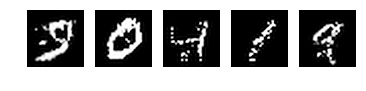

In [14]:
show_images(X_repr)

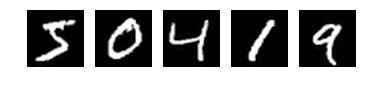

In [15]:
show_images(train_data.tensors[0][:num])

In [16]:
X_repr.data

tensor([[ 8.4666e-07,  5.7002e-07,  5.7947e-08,  ...,  4.3983e-07,
          5.2723e-07,  1.3887e-07],
        [ 1.0095e-08,  3.4100e-08,  5.2812e-09,  ...,  2.8471e-08,
          5.4647e-07,  1.4115e-07],
        [ 6.4606e-15,  1.9762e-16,  2.1503e-19,  ...,  6.1733e-16,
          6.0634e-17,  1.4671e-19],
        [ 4.0799e-22,  1.8735e-25,  6.0142e-30,  ...,  4.5725e-23,
          1.3495e-26,  1.1338e-27],
        [ 1.1408e-09,  3.7899e-10,  1.3188e-11,  ...,  1.0136e-09,
          2.7631e-10,  5.6943e-10]])

In [17]:
mu

tensor([[-3.6037, -3.2529],
        [ 2.9696, -5.0151],
        [-9.4092, -1.0527],
        [-4.0206,  8.4239],
        [ 2.6497,  3.8800]])